## Key point of Debevec is to reconstrcut the camera's response curve to incoming light. 
And then, a simple range compression is applied. This later part is more relevant to my problem. In that regard, Debevec is not very useful... Or is it? 


## Questions
* Can I assume **UNIFORM** response function of telescopes? -- probably, Yes.

# OpenCV HDR examples
## Debevec, Robertson and ...?

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

img_fn_base = "/home/hoseung/Work/tonemap/astroBF/notebooks/natural/StLouisArchMultExpEV"
fn_suffix = ["+4.09.jpeg", "+1.51.jpeg", "-1.82.jpeg" ,"-4.72.jpeg"]
img_list = [cv.imread(img_fn_base+fn) for fn in fn_suffix]
exposure_times = np.array([15.0, 2.5, 0.25, 0.0333], dtype=np.float32)

# Merge muliti-exposure images into one HDR image 
This step won't be necessary for astronomical images. 
So, let's just use a pre-built method.


Available TMOs in OpenCV are:  
cv::TonemapDrago, cv::TonemapMantiuk and cv::TonemapReinhard

In [10]:
# Merge exposures to HDR image
merge_debevec = cv.createMergeDebevec()
hdr_debevec = merge_debevec.process(img_list, times=exposure_times.copy())

merge_robertson = cv.createMergeRobertson()
hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy())

# Estimate camera response function (CRF)
cal_debevec = cv.createCalibrateDebevec()
crf_debevec = cal_debevec.process(img_list, times=exposure_times)
hdr_debevec = merge_debevec.process(img_list, times=exposure_times.copy(), response=crf_debevec.copy())
cal_robertson = cv.createCalibrateRobertson()
crf_robertson = cal_robertson.process(img_list, times=exposure_times)
hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy(), response=crf_robertson.copy())

# Tonemap HDR image
tonemap1 = cv.createTonemap(gamma=2.2)
res_debevec = tonemap1.process(hdr_debevec.copy())

res_robertson = tonemap1.process(hdr_robertson.copy())

# Exposure fusion using Mertens
merge_mertens = cv.createMergeMertens()
res_mertens = merge_mertens.process(img_list)

# Convert datatype to 8-bit and save
res_debevec_8bit = np.clip(res_debevec*255, 0, 255).astype('uint8')
res_robertson_8bit = np.clip(res_robertson*255, 0, 255).astype('uint8')
res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')
cv.imwrite("ldr_debevec_cali.jpg", res_debevec_8bit)
cv.imwrite("ldr_robertson_cali.jpg", res_robertson_8bit)
cv.imwrite("fusion_mertens.jpg", res_mertens_8bit)

# Custom implementation 

of Ashi..., Fattai (Gradient Domain High Dynamic Range Compression), and..?

No Devebec. It's just irrelevant

In [32]:
def world_capacity(l):
    """
    approximate form of human Threshold vs. Intensity curve. 
    eq.7 of Ashikhmin2002
    """
    conditions = [l < 0.0034, 
                  (l >= 0.0034) * (l < 1),
                  (l >= 1) * (l < 7.2444),
                  l >= 7.2444]
    functions = [lambda l : l / 0.0014,
                 lambda l : 2.4483 + np.log10(l/0.0034)/0.4027,
                 lambda l : 16.563 + (l-1)/0.4027,
                 lambda l : 32.0693 + np.log10(l/7.2444)/0.0556]
    
    return np.piecewise(l, conditions, functions)

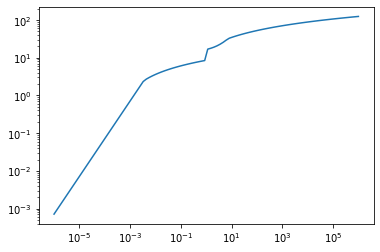

In [37]:
luminance=np.logspace(-6,6,100)
fig, ax = plt.subplots()
ax.plot(luminance, world_capacity(luminance))
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

## world and display correspondance

We will scale the min-max range of world to the min-max range of display.  
To prevent one outlying pixel baising the min-max range, take the minimum/maximum values from a blurred image.

In [41]:
def tonemapper(l, CLmin=0, CLmax = 1e6, LDmax=300):
    """
    get display luminance from world luminance
    
    Parameters
    ----------
    
    LDmax : float, [300]
    Assuming the maximum luminosity of display as 300cd/m^2
    
    """
    return LDmax * (world_capacity(l)-CLmin)/(CLmax - CLmin)

L_d = tonemapper(luminance)